In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def draw_graph(G,weights=None):
    pos=dict((n,n) for n in G.nodes)
    nx.draw(G, pos=pos, node_size=5, width=weights)
    plt.show()
    
def draw_weighted(G):
    weights = []
    for (e1,e2,weight) in G.edges(data=True):
        weights.append(weight['weight'])
    draw_graph(G,weights)

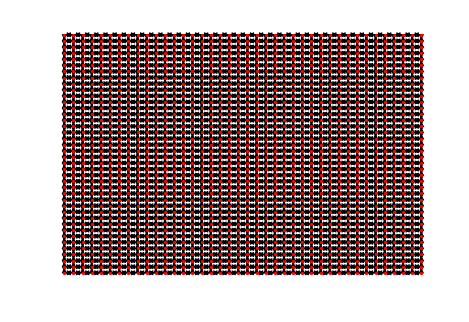

In [3]:
G = nx.grid_2d_graph(40,40)
G = G.to_directed()
draw_graph(G)

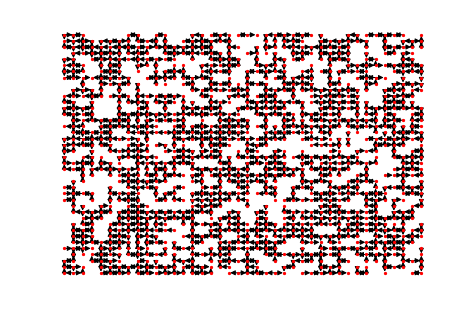

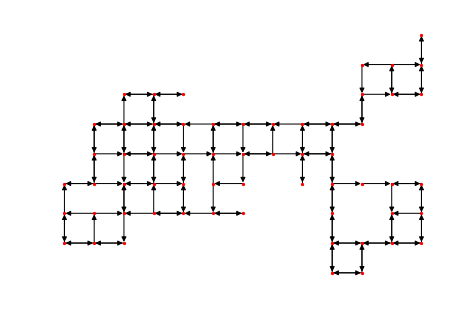

In [4]:
import random
prob_removing_node = 0.2
prob_removing_edge = 0.4

random.seed(34)

G_ruined = G.copy()
for node in G.nodes:
    if random.random() < prob_removing_node:
        G_ruined.remove_node(node)

for (a,b) in list(G_ruined.edges):
    if random.random() < prob_removing_edge:
        G_ruined.remove_edge(a,b)
        
undirected = G_ruined.to_undirected()

for node in list(undirected.nodes):
    if(undirected.degree[node] == 0):
        G_ruined.remove_node(node)

island = max((G_ruined.subgraph(c) for c in nx.strongly_connected_components(G_ruined)), key=lambda g: g.size())
        
draw_graph(G_ruined)
draw_graph(island)

In [5]:
import numpy as np

def min_max_scale(arr):
    max_arr = np.max(arr)
    min_arr = np.min(arr)
    return (arr - min_arr)/(max_arr - min_arr)

def create_weighted(edges_weights, weight_modifier):
    edges_weights[:,1] = weight_modifier(edges_weights[:,1])
    w_graph = nx.DiGraph()
    for edge_weight in edges_weights:
        w_graph.add_edge(edge_weight[0][0],edge_weight[0][1],weight=edge_weight[1])
    return w_graph

In [6]:
w_edges = nx.algorithms.centrality.edge_betweenness_centrality(island,normalized=False)
edges_weights = np.array(list(w_edges.items()))

w_graph = create_weighted(edges_weights, min_max_scale)

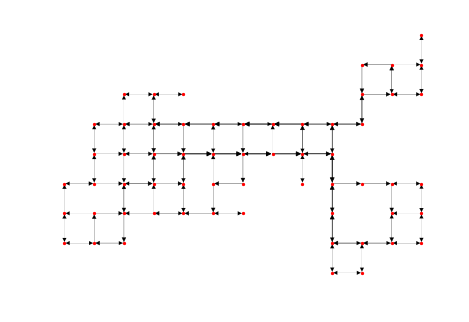

In [7]:
draw_weighted(w_graph)

We give the graph a score by checking how expensive are n random shortest paths

In [8]:
def sample_shortest_paths(G,num_trials = 5):
    total_length = 0
    for i in range(num_trials):

        nodes = list(G.nodes())
        i1 = random.randint(0, len(nodes)-1)
        i2 = random.randint(0, len(nodes)-1)

        total_length += nx.shortest_path_length(G, nodes[i1],nodes[i2],weight='weight')
    return total_length/num_trials

In [9]:
def permute_and_sample(n_samples):
    scores = []
    for i in range(n_samples):
        permuted = create_weighted(edges_weights, lambda x : min_max_scale(np.random.permutation(x)))
        cost = sample_shortest_paths(permuted)
        scores.append(cost)
    return np.array(scores)

In [10]:
our_graph = sample_shortest_paths(w_graph)
np.sum(our_graph < permute_and_sample(100))

5

Compared to 100 ohter randomly permuted graphs our graph is better than 95 of them. But this is for this specific sample of graphs. We can retry this experiment and come up with a confidence interval and actually see the distribution of the rank of our graph compared to randomly permuted ones

In [11]:
def graph_ranks_sample(n_samples):
    ranks = []
    for i in range(n_samples):
        our_graph = sample_shortest_paths(w_graph)
        rank = np.sum(our_graph < permute_and_sample(10))
        ranks.append(rank)
    return np.array(ranks)

(array([823.,  65.,  38.,  19.,  15.,   7.,  12.,   6.,   6.,   9.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

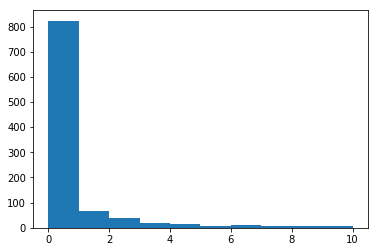

In [12]:
ranks = graph_ranks_sample(1000)
plt.hist(ranks)

As we can see the distribution of the rank of the graph we have indicates that our result is significant because it is highly likely that our graph would be ranked better than others even though we only sample each graph 5 times. The probability of our graph being is either the best or second best is:

In [13]:
np.mean(ranks <= 1)

0.888

It would be more likely for our graph to be better if we sampled it more. Also the probability would change if you repeat the rank experiment, so then you would have the distribution of the probability that our graph is in the interval we chose. Then you could repeat the question, what's the probability of getting a probability in a certain interval.